In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Training and visualizing

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

## 決定木の描画

dotファイルを作成し，pngに変換

In [4]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file=os.path.join('data', 'iris_tree.dot'),
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [5]:
!dot -Tpng data/iris_tree.dot -o data/iris_tree.png

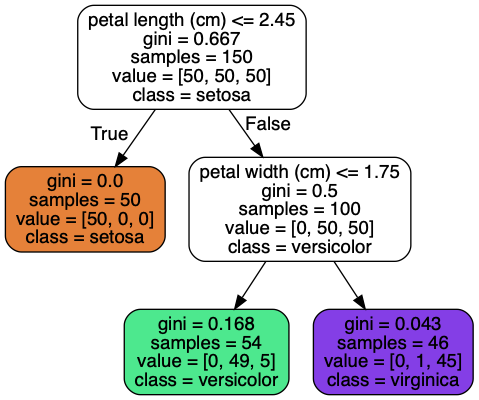

In [7]:
from IPython.display import Image, display_png
display_png(Image('data/iris_tree.png'))

samples: サンプル数  
values[]: 各クラスに分配されたサンプル数  
class: 予測されたクラス  
gini: ジニ不純度（$1 - \sum_{k=1}^n {p_{i,k}}^2$） (ex: 1-(49/54)^2-(5/54)^2 = 0.168)

## 決定木のアルゴリズム

CART(Classification and Regression Tree)アルゴリズムを使って学習する．  
コスト関数は，フィーチャー$k$, その閾値$t_k$の時，$$J(k, t_k) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right} $$
で表される．
CARTアルゴリズムは，ご覧の通り 「greedy algorithm」（貪欲法: 最適化問題を解く時，計算の各段階で最も利益の大きい部分会を選んでいく方法）であるため，最適解を生み出すことは保証されていない．  
残念ながら，最適な木を見つけるという問題は，**NP完全問題**であることがわかっている．

不純度の指標として，**エントロピー**を使う場合もある．エントロピーとは情報の乱雑さ（不純度）を示す指標としてよく使われる．  
エントロピーは，$\sum_{k=1}^n p_{i, k}log(p_{i, k})$で表される.  
実は，ジニ不純度とエントロピーどちらを使っても大差はない．ジニ不純度の方がわずかに高速なので，デフォルトとなっている．

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    # make grid data
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2, = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    # color
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    # draw prediction area
    plt.contourf(x1, x2, y_pred, alpha =0.3, cmap=custom_cmap)
    
    # some conditions
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

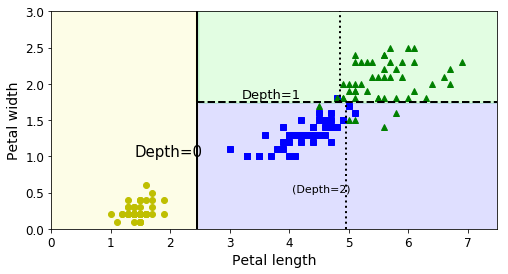

In [20]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)

plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

今回は深さ２で指定しているが，もしさらに深い木を作成すれば，（Depth=2）のような線が引かれるだろう．

# Predicting classes and class probabilities

In [22]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [23]:
tree_clf.predict([[5, 1.5]])

array([1])

# Sensitivity to training set details（不安定性）

決定木は**訓練データに対してほとんど先入観を持たない**（例えば，線形モデルなら，データが線形に分布していると最初から決めつけている）ので，制約を設けなければ，訓練データに合わせて自らを調整し訓練データに密接に適合する．**つまり過学習しやすい**  
このように予めモデルが決まっておらず訓練データに沿って構築されるモデルを**ノンパラメトリックモデル**と言う．

反対に，線形モデルなど予め「型」が決まっているものは**パラメトリックモデル**といい，自由度が制限されるため，過学習のリスクが低くなる．

決定木では，min_*パラメータを増やすか，max_*パラメータを減らせば基本的に正則化の動きをする．

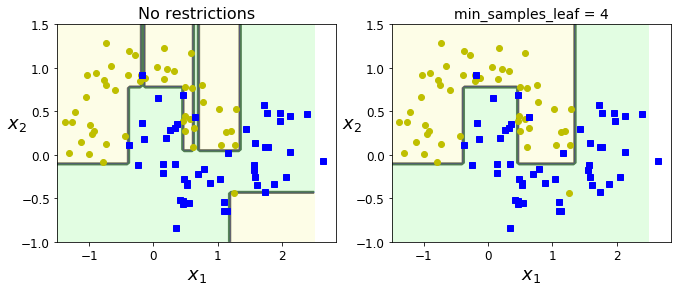

In [24]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

# default parameter
deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
# reqularization by using min_*
# 下記は，１つの葉が含んでいなければならない最低限のサンプル数（これを指定すれば，サンプルが１しか含まれないような葉が出来上がらない）
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.show()

正則化をかけたほうが，汎化性能が高くみえる．

## remove a distinctive data

小さな変化に敏感すぎる例

In [25]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris-Versicolor flower

array([[4.8, 1.8]])

In [ ]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

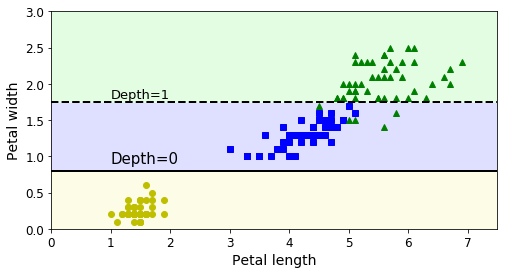

In [28]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

plt.show()

特徴的なインスタンスを１つ省くだけで，決定木は全然違うものに

## rotate all data

決定木の決定境界は**直線**なので，回転させると結果が変わる．

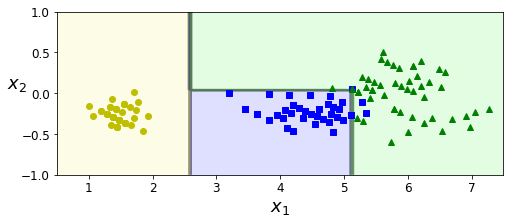

In [29]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

少し回転させても，決定木は全然違うものに

別のデータの例

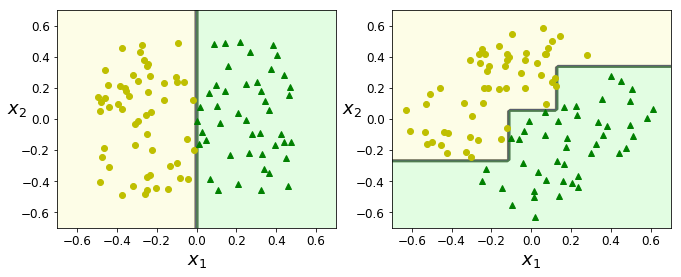

In [30]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.show()

左の方が汎化性能が高そう  
この問題は，訓練データをより良い向きに変えられることの多いPCAを使えばある程度軽減できる．

scikit-learnのアルゴリズムは確率的（各ノードを評価するフィーチャーセットを無作為に選ぶ）なので，random_stateを固定しなければ，実行するたびに違うモデルが導かれることに注意しよう．

**このようにノンパラメトリックモデルは「モデルの型」が決まっているわけでなないので，分類の仕方はインスタンスに依存する**

この問題を解消するために，**ランダムフォレスト**によって多数の木の平均をとることが考えられた．